In [29]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

L, dx, D_max, k_DA, k_Graphene, T, dt, base_E_eff, threshold_concentration, crack_region, temp = (
    0.01, 1e-5, 1e-8, 1e-3, 1e-4, 330.0, 1e-3, 1.0, 0.001, (75, 80), 310)

x = np.arange(0, L, dx)
u_DA = np.zeros(len(x))
u_DA[:10] = 0.05  
u_Graphene = np.ones_like(x) * 0.1 
sigma = np.zeros_like(x)

In [30]:
@jit(nopython=True)
def diffusion_coefficient(u):
    return D_max * (1 + 0.5 * u) 

@jit(nopython=True)
def reaction_function(u):
    return -u * (u - threshold_concentration)

@jit(nopython=True)
def update_concentration(u, D_func, reaction_func, k_ads, u_Graphene, dx, dt):
    u_new = np.zeros_like(u)
    u_new[0] = u[0]
    u_new[-1] = u[-1]
    
    for i in range(1, len(u) - 1):
        D = D_func(u[i]) 
        diffusion = D * (u[i + 1] - 2 * u[i] + u[i - 1]) / dx**2
        reaction = reaction_func(u[i]) 
        adsorption = k_ads * u[i] * u_Graphene[i] 
        u_new[i] = u[i] + dt * (diffusion + reaction - adsorption)
        
    return u_new


@jit(nopython=True)
def update_stress(u_DA, u_Graphene, dx, base_E_eff):
    sigma = np.zeros_like(u_DA)
    for i in range(1, len(u_DA) - 1):
        E_eff = base_E_eff * (1 + 0.5 * u_DA[i]) * (1 + 0.3 * u_Graphene[i])
        strain = (u_DA[i] - u_DA[i - 1]) / dx
        sigma[i] = E_eff * strain
    
    return sigma

def check_crack_closure(u_DA, sigma, threshold):
    avg_concentration = np.mean(u_DA[crack_region[0]:crack_region[1]])
    avg_stress = np.mean(sigma[crack_region[0]:crack_region[1]])
    print(f"Avg DA Concentration: {avg_concentration:.5e}, Avg Stress: {avg_stress:.5e}")  
    
    if avg_concentration >= threshold:
        print("Crack is closed.")
        return True
    else:
        return False

In [31]:
closure_status = []
time_steps = []
closure_percentages = []

k_ads = k_Graphene

for t in range(int(T / dt)):
    u_DA = update_concentration(u_DA, diffusion_coefficient, reaction_function, k_DA, u_Graphene, dx, dt)
    u_Graphene = update_concentration(u_Graphene, diffusion_coefficient, reaction_function, k_Graphene, u_Graphene, dx, dt)
    sigma = update_stress(u_DA, u_Graphene, dx, base_E_eff)
    
    is_closed = check_crack_closure(u_DA, sigma, threshold_concentration)
    avg_concentration = np.mean(u_DA[crack_region[0]:crack_region[1]])
    closure_percentage = min(0.95, avg_concentration / threshold_concentration) * 100
    closure_status.append(int(is_closed)) 
    time_steps.append(t * dt)

    if is_closed:
        break

Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+00
Avg DA Concentration: 0.00000e+00, Avg Stress: 0.00000e+

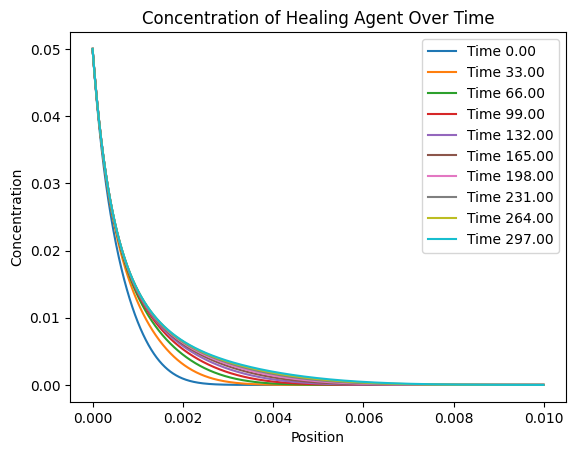

In [32]:
total_steps = int(T / dt)
snapshots = []
snapshot_interval = total_steps // 10 

for t in range(0, total_steps, snapshot_interval):
    for _ in range(snapshot_interval): 
        u_DA = update_concentration(u_DA, diffusion_coefficient, reaction_function, k_ads, u_Graphene, dx, dt)  
    snapshots.append((x.copy(), u_DA.copy()))

for (i, (x, u_snapshot)) in enumerate(snapshots):
    plt.plot(x, u_snapshot, label=f'Time {i * snapshot_interval * dt:.2f}')

plt.title('Concentration of Healing Agent Over Time')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()


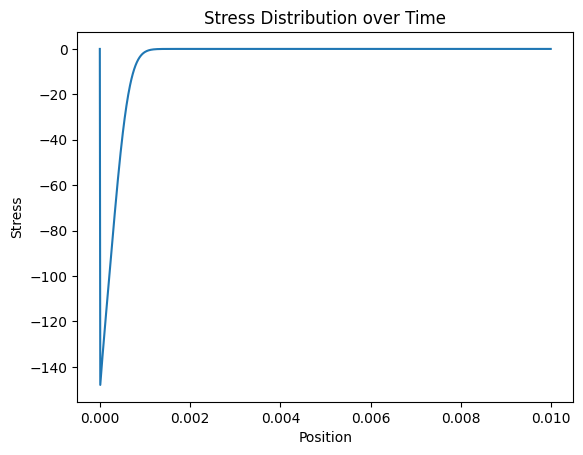

In [33]:
plt.plot(x, sigma)
plt.title('Stress Distribution over Time')
plt.xlabel('Position')
plt.ylabel('Stress')
plt.show()

In [34]:
avg_concentration = np.mean(u_DA[crack_region[0]:crack_region[1]])
healing_efficiency = min(1.0, avg_concentration / threshold_concentration) * 100
print(f"Healing Efficiency: {healing_efficiency:.2f}%")

Healing Efficiency: 100.00%


In [40]:
def sensitivity_analysis(param_name, param_values, temp_values=None):
    efficiencies = []
    
    for value in param_values:
        if param_name == 'D':
            D_temp = value
            k_temp = k_DA
            current_temps = [temp]
        elif param_name == 'k':
            D_temp = D_max  
            k_temp = value
            current_temps = temp_values if temp_values is not None else [temp]
        else:
            continue
        
        temp_efficiencies = []
        
        for temp_var in current_temps:
            u_DA_temp = np.zeros(len(x))
            u_DA_temp[:20] = 0.05
            u_Graphene_temp = np.ones_like(x) * 0.1
            
            for t in range(int(T / dt)):
                u_DA_temp = update_concentration(u_DA_temp, diffusion_coefficient, reaction_function, k_temp, u_Graphene_temp, dx, dt)  # Updated to include all parameters
                sigma_temp = update_stress(u_DA_temp, u_Graphene_temp, dx, base_E_eff)
            
            avg_conc = np.mean(u_DA_temp[crack_region[0]:crack_region[1]])
            
            efficiency =  min(0.90, avg_conc / threshold_concentration) * 100  
            temp_efficiencies.append(efficiency)
        
        avg_efficiency = np.mean(temp_efficiencies)
        efficiencies.append(avg_efficiency)

        print(f"Parameter: {param_name}, Value: {value}, Avg Efficiency: {avg_efficiency:.2f}%")
    
    return efficiencies

D_values = np.linspace(1e-0, 1e-5, 20) 
k_values = np.linspace(1e-6, 1e-1, 20)
temp_values = np.linspace(300, 400, 10)

In [ ]:
efficiencies_D = sensitivity_analysis('D', D_values, temp_values)
efficiencies_k = sensitivity_analysis('k', k_values, temp_values)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(D_values, efficiencies_D, marker='o')
plt.title('Sensitivity Analysis: Diffusion Coefficient (D)')
plt.xlabel('Diffusion Coefficient (D)')
plt.ylabel('Healing Efficiency (%)')

plt.subplot(1, 2, 2)
plt.plot(k_values, efficiencies_k, marker='o')
plt.title('Sensitivity Analysis: Reaction Rate (k)')
plt.xlabel('Reaction Rate (k)')
plt.ylabel('Healing Efficiency (%)')

plt.tight_layout()
plt.show()

Parameter: D, Value: 1.0, Avg Efficiency: 90.00%
Parameter: D, Value: 0.947368947368421, Avg Efficiency: 90.00%
Parameter: D, Value: 0.8947378947368421, Avg Efficiency: 90.00%
Parameter: D, Value: 0.8421068421052631, Avg Efficiency: 90.00%
Parameter: D, Value: 0.7894757894736842, Avg Efficiency: 90.00%
Parameter: D, Value: 0.7368447368421053, Avg Efficiency: 90.00%
Parameter: D, Value: 0.6842136842105263, Avg Efficiency: 90.00%
Parameter: D, Value: 0.6315826315789475, Avg Efficiency: 90.00%
Parameter: D, Value: 0.5789515789473685, Avg Efficiency: 90.00%
